In [5]:
%matplotlib inline
import seaborn
import numpy as np, scipy, IPython.display as ipd, matplotlib.pyplot as plt
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

In [6]:
filename = '../../data/flute.wav'
x, sr = librosa.load(filename,duration=10)

In [7]:
ipd.Audio(x,rate=sr)

CQT of the signal:  
similar to fourier transform but uses logarithmically spaced frequency axis.



In [8]:
bins_per_octave = 36

cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave = bins_per_octave)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))

In [9]:
cqt.shape


(300, 431)

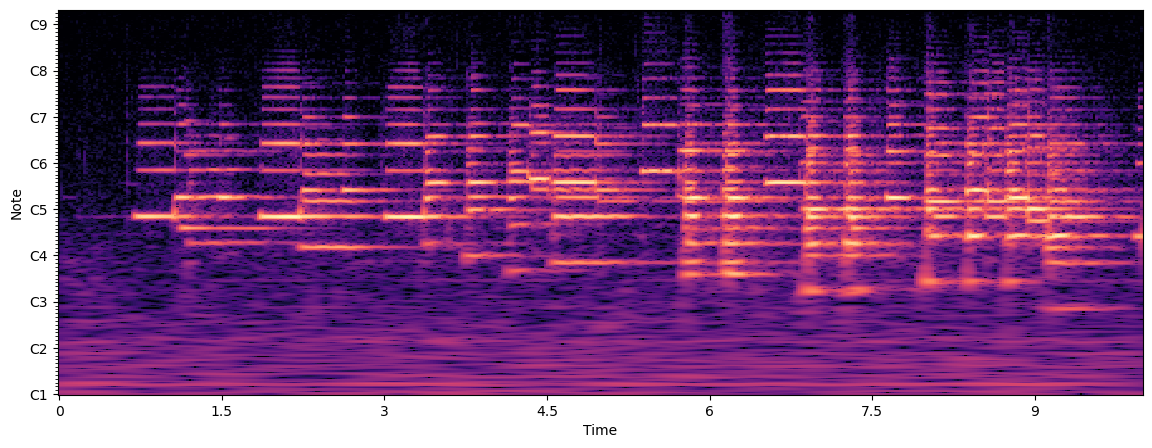

In [10]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note',bins_per_octave = bins_per_octave)

STEP 1: Detect onsets

In [11]:
hop_length = 100
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_14713/856406037.py:2: FutureWarning: Pass y=[ 4.2360881e-07 -6.2635831e-07  8.9503169e-07 ... -1.1032463e-02
 -2.6670808e-03  4.6673901e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)


(0.0, 2206.0)

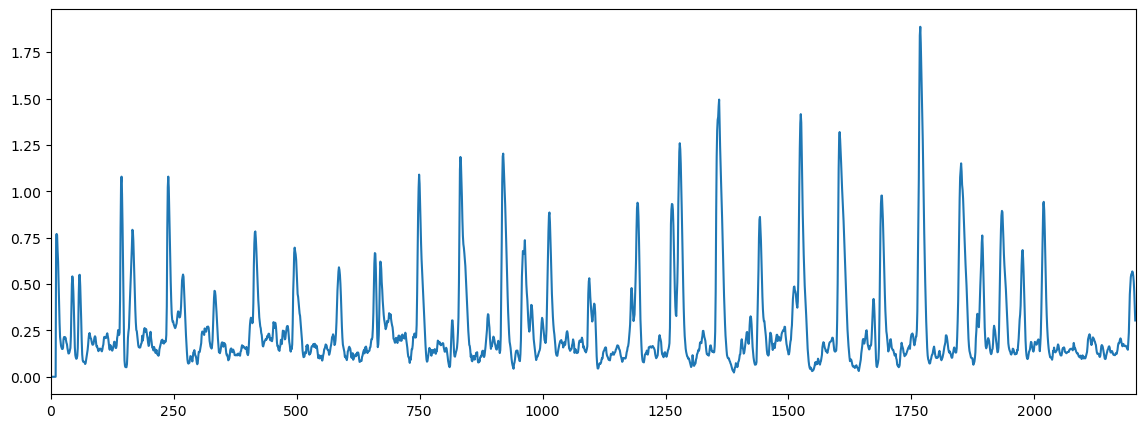

In [12]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

In [13]:
onset_samples = librosa.onset.onset_detect(x, sr=sr, units='samples',
hop_length=hop_length, backtrack=False, pre_max=20, post_max=20, 
pre_avg=100, post_avg=100, delta=0.2, wait=0)

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_14713/2947029760.py:1: FutureWarning: Pass y=[ 4.2360881e-07 -6.2635831e-07  8.9503169e-07 ... -1.1032463e-02
 -2.6670808e-03  4.6673901e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_samples = librosa.onset.onset_detect(x, sr=sr, units='samples',


In [14]:
onset_samples

array([  1200,  14400,  23900,  41600,  49600,  65900,  74900,  83300,
        92000,  96400, 101400, 119300, 127900, 135900, 144200, 152500,
       160400, 169000, 176800, 185100, 189400, 193400, 197600, 201900])

In [15]:
onset_boundaries = np.concatenate([[0], onset_samples, [len(x)]])

In [16]:
print(onset_boundaries)

[     0   1200  14400  23900  41600  49600  65900  74900  83300  92000
  96400 101400 119300 127900 135900 144200 152500 160400 169000 176800
 185100 189400 193400 197600 201900 220500]


In [17]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)
onset_times

array([ 0.        ,  0.05442177,  0.65306122,  1.08390023,  1.88662132,
        2.24943311,  2.98866213,  3.3968254 ,  3.77777778,  4.1723356 ,
        4.37188209,  4.59863946,  5.41043084,  5.80045351,  6.16326531,
        6.53968254,  6.91609977,  7.27437642,  7.66439909,  8.01814059,
        8.39455782,  8.58956916,  8.77097506,  8.96145125,  9.15646259,
       10.        ])

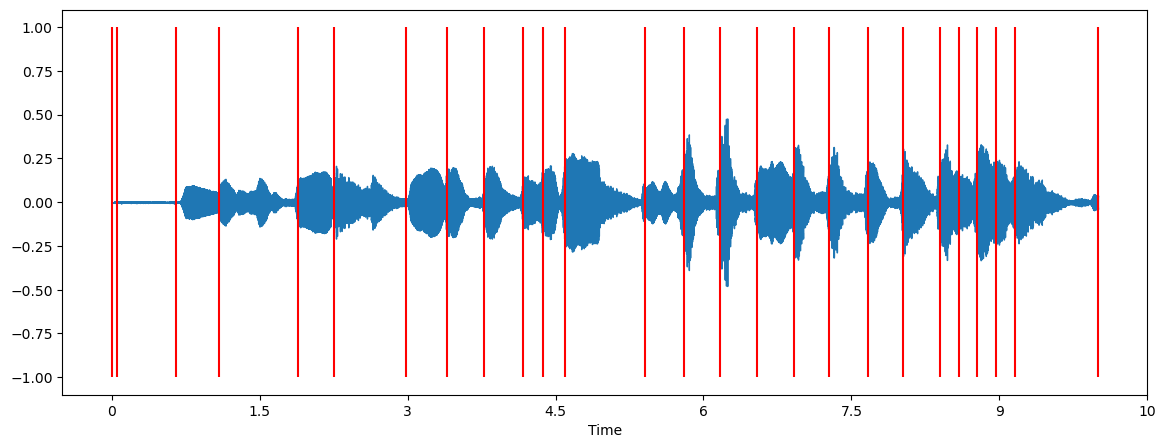

In [18]:
librosa.display.waveshow(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

In [19]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

In [20]:
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [21]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [22]:
y = np.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [23]:
ipd.Audio(y, rate=sr)

In [24]:
cqt = librosa.cqt(y, sr=sr)


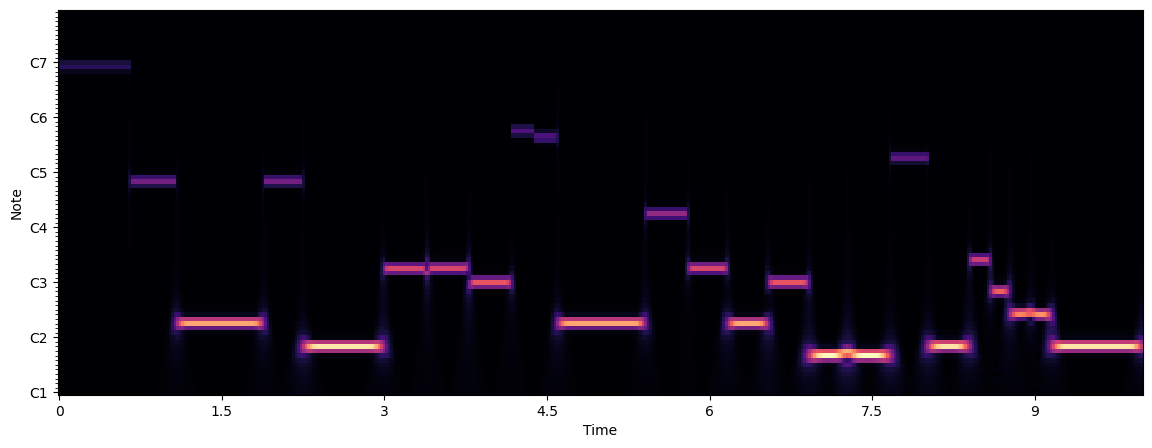

In [25]:
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')